## Milestone Project 1: Food Vision Big

## Check GPU

Google Colab offers free GPUs! However, not all of the are compatibile with mixed precision training. 

Colab offers:
* K80 (not compatible)
* P100 (not compatibile)
* T4 (compatibile)

Knowing this, in order to use mixed precision training we need acccess to a Tesla T4 unit. If you're using your own hardware, it needs the score of +7.0 from NVidia site.

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-11d61643-2903-23bf-ece2-3838be7c8b08)


## Get helper functions

A pack of functions from earlier notebooks:
https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
# Download .py file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-03-06 18:23:08--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-06 18:23:09 (79.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to download data

An overview of TFDS: 
https://www.tensorflow.org/datasets/overview?hl=en

In [4]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [5]:
# List all avaliable datasets
datasets_list = tfds.list_builders() # get all avaliable datasets
print('food101' in datasets_list) # is our dataset there?

True


In [6]:
# Download the data (approx. 5GB of images), may take 5-6 minutes in Colab
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteFX1E1M/food101-train.tfrecord*...:   0%|          …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteFX1E1M/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [7]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
# Get the class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Exploring the Food101 data from TensorFlow Datasets

To become one with our data we want to find:
* class names
* shape of input data (image tensors)
* the datatype of our input data (are the one-hot encoded or are they label encoded)
* do the labels match our class names

In [9]:
# Take one sample of the train data
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
train_one_sample = train_data.take(1) # are in format (image_tensor, label)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tenosr form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tenosr form): 65
  Class name (str form): mussels
  


In [12]:
# What does our image tensor look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 19,   6,   0],
        [ 29,  16,   8],
        [ 34,  21,  13],
        ...,
        [ 36,  19,   3],
        [ 35,  19,   3],
        [ 36,  20,   4]],

       [[ 20,   7,   0],
        [ 28,  15,   7],
        [ 34,  21,  13],
        ...,
        [ 37,  20,   4],
        [ 37,  20,   4],
        [ 37,  21,   5]],

       [[ 20,   7,   0],
        [ 25,  12,   4],
        [ 31,  18,  10],
        ...,
        [ 40,  21,   4],
        [ 40,  21,   4],
        [ 39,  22,   4]],

       ...,

       [[208, 206, 194],
        [209, 207, 195],
        [211, 209, 197],
        ...,
        [192, 196, 179],
        [190, 194, 177],
        [203, 207, 190]],

       [[208, 206, 194],
        [209, 207, 195],
        [210, 208, 196],
        ...,
        [203, 207, 190],
        [211, 214, 197],
        [202, 205, 186]],

       [[208, 206, 194],
        [209, 207, 195],
        [210, 208, 196],
        ...,
        [200, 204, 18

In [13]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TFDS

(-0.5, 511.5, 511.5, -0.5)

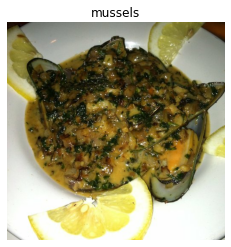

In [14]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

## Create preprocessing functions for our data

Neural networks perform best when data is in a certain way (batched, normalized, etc.).

However, not all data (indluding the one from TensorFlow Datasets) comes like this.

So in order to get it ready for our neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different size images)
* Not normalized (values between 0 and 255)

What we know models like:
* data in `float32` dtype (or `float16` and `float32` for mixed precision operation)
* for batches, TensorFlow likes all of the tensors within a batch to be of the same size
* scaled (values between 0 and 1) also called normalized tensors, generally perform better

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Sice we'll be using and EfficientNetBX pretrained model from `tf.keras.applications` we don't need to rescale our data. These architecture have rescaling built-in.

This means our functions needs to:
1. Reshape our image to all the same size
2. Convert the dtype of our images from `uint8` to `float32`.

In [15]:
# Make a function for preprocessing images
def preprocessing_img(image, label, img_shape=224):
  """
  Converts image datatype fron 'uint8' -> 'float32' 
  and reshapes image to [img_shape, img_shape, color_channels].
  """
  # Reshape target image
  image = tf.image.resize(image, [img_shape, img_shape])

  # Scale image values
  # image = image/225. - NOT REQUIRED WITH EFFICIENTNET BX ARCHITECTURE

  # Return (float32, label) tuple
  return tf.cast(image, tf.float32), label

In [16]:
# Preprocess a single sample image and check the output
preprocessed_img = preprocessing_img(image, label)[0]

In [17]:
print(f"Image before preprocessing:\n {image[:2]}... \nShape: {image.shape} \nDatatype: {image.dtype}")
print(f"Image after preprocessing: \n {preprocessed_img[:2]}... \nShape: {preprocessed_img.shape} \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[19  6  0]
  [29 16  8]
  [34 21 13]
  ...
  [36 19  3]
  [35 19  3]
  [36 20  4]]

 [[20  7  0]
  [28 15  7]
  [34 21 13]
  ...
  [37 20  4]
  [37 20  4]
  [37 21  5]]]... 
Shape: (512, 512, 3) 
Datatype: <dtype: 'uint8'>
Image after preprocessing: 
 [[[25.244898   12.244898    4.7295923 ]
  [32.40816    19.408163   11.408163  ]
  [32.719387   19.719387   10.719387  ]
  ...
  [39.005093   20.994862    3.4999783 ]
  [36.31123    19.31123     2.1173685 ]
  [36.413277   20.000034    4.000035  ]]

 [[19.897957    6.897958    0.18367267]
  [28.943878   15.943878    7.9438777 ]
  [22.112244    9.112244    1.1122437 ]
  ...
  [48.89794    27.015284    6.1428356 ]
  [44.642845   23.852028    3.0714417 ]
  [42.7602     21.954084    3.0714283 ]]]... 
Shape: (224, 224, 3) 
Datatype: <dtype: 'float32'>


## Batch & prepare datasets

We're going to make pur data input pipeline run really fast.

For more resources on this, I'd higly recommend going through the guide:
https://www.tensorflow.org/guide/data?hl=en

In [18]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocessing_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocessing_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

In [19]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> 'Hey, TensorFlow, map this preprocessing function (`preprocessing_img`) across our training dataset, then shuffle a number of elements adn then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch.'

## Create modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard callback t o log training results (so we can visualize them later if needed)
* ModelCheckpoint callback to save our model's peogress after feature extraction

In [78]:
# Create TensorBoard callback
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress during training
checkpoint_path = 'model_checkpoints/cp.ckpt'
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                    monitor='val_accuracy',
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    verbose=1)                                              

## Setup mixed precision training

First and foremost, for a deeper undestanding of mixed presicion training, check out TensorFlow guide for mixed precision training.

Guide: https://www.tensorflow.org/guide/mixed_precision?hl=en

Mixed precision utilizes a combination of float16 and float32 dtypes to speed up model's performance.

In [21]:
# Turn on mixed precision training 
from tensorflow.keras import mixed_precision

# Set global data policy to mixed precision with float16
mixed_precision.set_global_policy('mixed_float16') 

mixed_precision.global_policy()

<Policy "mixed_float16">

In [22]:
!nvidia-smi

Mon Mar  6 18:39:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    26W /  70W |    335MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Build feature extraction model

In [79]:
#from tensorflow.keras import Layers
from tensorflow.keras.layers.experimental import preprocessing

# Fixing the serialization error?
#IMAGENET_STDDEV_RGB = [0.229, 0.224, 0.225]
#IMAGENET_STDDEV_RGB = [1/math.sqrt(i) for i in IMAGENET_STDDEV_RGB]

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')

# Note: EfficientNetBX have resaling built in but if your model does not, you can use as below
# Fixing the serialization error?
#x = tf.keras.layers.Rescaling(IMAGENET_STDDEV_RGB)(inputs)

x = base_model(inputs, training=False) # makes sure layers which should be in inference stay frozen
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation('softmax', dtype=tf.float32, name='softmanx_float32')(x)

model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [71]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 101)               129381    
                                                                 
 softmanx_float32 (Activatio  (None, 101)              0         
 n)                                                              
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

## Checking layer dtype policies (are we using mixed precision)?

In [72]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.dtype, layer.dtype_policy, layer.name, layer.trainable)

float32 <Policy "float32"> input_layer True
float32 <Policy "mixed_float16"> efficientnetb0 False
float32 <Policy "mixed_float16"> global_average_pooling2d_3 True
float32 <Policy "mixed_float16"> dense_3 True
float32 <Policy "float32"> softmanx_float32 True


Going through the above we can see:
* `layer.name`: is the human trainable name of a particular layer
* `layer.trainable`: is the layer trainable or not (if `False`, the weights are frozen)
* `layer.dtype`: the datatype on which the layer stores its variables
* `layer.dtype_policy`: is the datatype policy a layer computes on its variables with

In [73]:
# Check the layers in base_model being EfficientNetB0
#for layers in model.layers[1].layers:
for layer in base_model.layers:
  print(layer.dtype, layer.dtype_policy, layer.name, layer.trainable)

float32 <Policy "float32"> input_4 False
float32 <Policy "mixed_float16"> rescaling_7 False
float32 <Policy "mixed_float16"> normalization_3 False
float32 <Policy "mixed_float16"> rescaling_8 False
float32 <Policy "mixed_float16"> stem_conv_pad False
float32 <Policy "mixed_float16"> stem_conv False
float32 <Policy "mixed_float16"> stem_bn False
float32 <Policy "mixed_float16"> stem_activation False
float32 <Policy "mixed_float16"> block1a_dwconv False
float32 <Policy "mixed_float16"> block1a_bn False
float32 <Policy "mixed_float16"> block1a_activation False
float32 <Policy "mixed_float16"> block1a_se_squeeze False
float32 <Policy "mixed_float16"> block1a_se_reshape False
float32 <Policy "mixed_float16"> block1a_se_reduce False
float32 <Policy "mixed_float16"> block1a_se_expand False
float32 <Policy "mixed_float16"> block1a_se_excite False
float32 <Policy "mixed_float16"> block1a_project_conv False
float32 <Policy "mixed_float16"> block1a_project_bn False
float32 <Policy "mixed_float16"

In [74]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [75]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Fit the feature extraction model

If our model is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple output layers with base layers frozen)
2. Fine-tune some of the frozen layers

In [80]:
# Fitting the model for 3 epochs with ModelCheckpoint and TensorBoard callbacks
history_101_food_classes = model.fit(x=train_data, 
                                     epochs=3,
                                     steps_per_epoch=len(train_data),
                                     validation_data=test_data,
                                     validation_steps=int(0.15*len(test_data)),
                                     callbacks=[create_tensorboard_callback(dir_name='tensorboard_callback', 
                                                                            experiment_name='food_vision_big'),
                                                model_checkpoint])

Saving TensorBoard log files to: tensorboard_callback/food_vision_big/20230306-200449
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7166 - accuracy: 0.5828
Epoch 1: val_accuracy improved from -inf to 0.69836, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 202s 81ms/step - loss: 1.7166 - accuracy: 0.5828 - val_loss: 1.1211 - val_accuracy: 0.6984
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.1990 - accuracy: 0.6884
Epoch 2: val_accuracy improved from 0.69836 to 0.72219, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 192s 80ms/step - loss: 1.1989 - accuracy: 0.6884 - val_loss: 1.0232 - val_accuracy: 0.7222
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.0534 - accuracy: 0.7236
Epoch 3: val_accuracy improved from 0.72219 to 0.72696, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 186s 78ms/step 

In [81]:
# Evaluate model on whole test dataset
result_feature_extraction = model.evaluate(test_data)
result_feature_extraction

790/790 [==============================] - 55s 70ms/step - loss: 0.9919 - accuracy: 0.7293


[0.9919065833091736, 0.729346513748169]

## Off to you...

We've covered a lot of ground so far but since this is a milestone project it's time for you to takeover. 

More specifically, the challenge is to complete the TEMPLATE version of 07 notebook to obtain a computer vision model (builidng off ther one we've built in this notebook) to beat DeepFood paper.

In other words, you're going to create Food Vision Big!


### TODO: Save the whole model to file
> **NOTE:** As there's some serialization error, model cannot be saved directly as neither H5 or SavedModel format. Therefore this step will be left untouched for now.

In [82]:
# Cloning a model and loading previously saved model weights from ModelCheckpoint
loaded_model = tf.keras.models.clone_model(model=model)
loaded_model.load_weights(checkpoint_path)

In [83]:
# Check the loaded model performance
loaded_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

results_loaded_model = loaded_model.evaluate(test_data)

790/790 [==============================] - 59s 70ms/step - loss: 1.3586 - accuracy: 0.6363


In [88]:
# Check the layer in loaded model
loaded_model.layers[1].layers[:20]

In [ ]:
for layer in loaded_model.layers[1].layers:
  print(layer.name, layer.dtype, layer.dtype_policy, layer.trainable)

In [91]:
# Checking if the results are close
import numpy as np
assert np.isclose(result_feature_extraction, results_loaded_model).all(), 'Weights are not close!'

AssertionError: ignored

Looks alike earlier created and trained `model` does not perform exactly the same as copied fed with its weights `loaded_model`. The *dtype_policy* was carried on, however it's still possible to continue and fine-tune this particular model (`loaded_model`).

In [101]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 

# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

--2023-03-06 20:37:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  9.29MB/s    in 1.7s    

2023-03-06 20:38:00 (9.29 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_g

In [ ]:
# Load and evaluate the GS model
model_gs = tf.keras.models.load_model('downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/')

model_gs.evaluate(test_data)

In [ ]:
# Get the summary of the model
model_gs.summary()

### TODO: Preparing the model for fine-tuning

In [109]:
# Set all of the layers to 'trainable'
for layer in model.layers:
  layer.trainable = True
  print(layer.name, layer.trainable, layer.dtype_policy)


input_layer True <Policy "float32">
efficientnetb0 True <Policy "mixed_float16">
global_average_pooling2d_4 True <Policy "mixed_float16">
dense_4 True <Policy "mixed_float16">
softmanx_float32 True <Policy "float32">


In [ ]:
# Check the dtype_policy for base_model
for layer in model.layers[1].layers:
  print(layer.trainable, layer.dtype, layer.dtype_policy)

In [111]:
# Setup the EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=3,
                                              verbose=1,
                                              restore_best_weights=True)

In [118]:
# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = 'fine-tuning-checkpoint/'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                      verbose=1,
                                                      save_weights_only=True,
                                                      monitor='val_loss')

In [119]:
# Compile the model ready for fine-tuning
initial_epochs = 3
fine_tune_epochs = initial_epochs + 100

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [ ]:
# Start to fine-tune the model
fine_tune_history = model.fit(train_data,
                              epochs=fine_tune_epochs,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.15*len(test_data)),
                              initial_epoch=history_101_food_classes.epoch[-1],
                              callbacks=[create_tensorboard_callback(dir_name='tensorboard_callback',
                                                                     experiment_name='fine_tune_model'),
                                         model_checkpoint, 
                                         early_stop])

Saving TensorBoard log files to: tensorboard_callback/fine_tune_model/20230306-211835
Epoch 3/103
2368/2368 [==============================] - ETA: 0s - loss: 0.5432 - accuracy: 0.8480
Epoch 3: saving model to fine-tuning-checkpoint/
2368/2368 [==============================] - 440s 164ms/step - loss: 0.5432 - accuracy: 0.8480 - val_loss: 0.7515 - val_accuracy: 0.7913
Epoch 4/103
 229/2368 [=>............................] - ETA: 5:33 - loss: 0.2968 - accuracy: 0.9189

In [117]:
tf.__version__

'2.11.0'

In [ ]:
# Workaround for TF 2.10 & 2.11 issue: https://github.com/keras-team/keras/issues/17199: "efficientnetBx model.save() fails due to serialization problem with tf2.10.0"
!RUN sudo sed -i 's/IMAGENET_STDDEV_RGB = \[0.229, 0.224, 0.225\]/IMAGENET_STDDEV_RGB = \[1 \/ math.sqrt(i) for i in \[0.229, 0.224, 0.225\]\]/g' \
    /usr/local/lib/python3.8/dist-packages/keras/applications/efficientnet.py && \
    sudo sed -i 's/x = layers.Rescaling(1.0 \/ tf.math.sqrt(IMAGENET_STDDEV_RGB))(x)/x = layers.Rescaling(IMAGENET_STDDEV_RGB)(x)/g' \
    /usr/local/lib/python3.8/dist-packages/keras/applications/efficientnet.py